# [Assignment 11](https://ovgu-ailab.github.io/idl2023/assignment11.html)

Adrian Bremer

## Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tfk.layers

2024-01-11 19:55:05.119494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 19:55:05.256154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:55:05.256206: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:55:05.256690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 19:55:05.318923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 19:55:05.320430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [11]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tfk.datasets.cifar10.load_data()

train_imgs = np.array(train_imgs / 255, np.float32)
train_lbls = np.reshape(train_lbls.astype(np.int32), 50000)
test_imgs = np.array(test_imgs / 255, np.float32)
test_lbls = np.reshape(test_lbls.astype(np.int32), 10000)

train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls)).shuffle(50000).batch(128).repeat()
test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_lbls)).shuffle(10000).batch(128)

print(np.shape(train_imgs), np.shape(train_lbls), np.shape(test_imgs), np.shape(test_lbls))

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


## Building the model

In [3]:
def resblock(x, filters, kernel_size):
  in_channels = x.shape[3]
  stride = 1
  add_x = x
  if 2*in_channels == filters:
    # assume
    stride = 2
    add_x = tfkl.Conv2D(filters, 1, stride, padding="same")(x)
  elif in_channels == filters:
    pass
  #else:
  #  raise AssertionError("When changing dimensions (filters) it has to be doubled.")

  out = tfkl.Conv2D(filters, kernel_size, stride, activation="relu", padding="same")(x)
  out = tfkl.BatchNormalization()(out)
  out = tfkl.Conv2D(filters, kernel_size, activation="relu", padding="same")(out)
  out = tfkl.Add()([add_x, out])
  out = tfkl.ReLU()(out)
  out = tfkl.BatchNormalization()(out)

  return out

def group_of_resblocks(n, x, filters, kernel_size):
  out = x
  for _ in range(n):
    out = resblock(out, filters, kernel_size)
  return out

def build_model():
    input = tfk.Input(shape=(32,32,3))
    out = tfkl.Conv2D(filters=32, kernel_size=5, strides=2, padding="same")(input)
    out = tfkl.MaxPooling2D()(out)
    out = group_of_resblocks(2, out, 64, 3)
    #out = group_of_resblocks(2, out, 128, 3)
    #out = group_of_resblocks(6, out, 256, 3)
    #out = group_of_resblocks(3, out, 512, 3)
    out = tfkl.AveragePooling2D()(out)
    out = tfkl.Flatten()(out)
    out = tfkl.Dense(10)(out)

    model = tfk.Model(inputs=input, outputs=out, name="copy_from_paper")
    return model

model = build_model()
model.compile(optimizer="adam", loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

#tfk.utils.plot_model(model, show_shapes=True)

In [4]:
model.fit(train_data, epochs=15, steps_per_epoch=500)

Epoch 1/15
500/500 [==============================] - 13s 24ms/step - loss: 1.3364 - accuracy: 0.5189
Epoch 2/15
500/500 [==============================] - 12s 23ms/step - loss: 0.9874 - accuracy: 0.6504
Epoch 3/15
500/500 [==============================] - 12s 23ms/step - loss: 0.8250 - accuracy: 0.7084
Epoch 4/15
500/500 [==============================] - 12s 23ms/step - loss: 0.6974 - accuracy: 0.7545
Epoch 5/15
500/500 [==============================] - 12s 23ms/step - loss: 0.5927 - accuracy: 0.7924
Epoch 6/15
500/500 [==============================] - 11s 23ms/step - loss: 0.5089 - accuracy: 0.8207
Epoch 7/15
500/500 [==============================] - 12s 23ms/step - loss: 0.4452 - accuracy: 0.8429
Epoch 8/15
500/500 [==============================] - 12s 23ms/step - loss: 0.3514 - accuracy: 0.8794
Epoch 9/15
500/500 [==============================] - 12s 23ms/step - loss: 0.2972 - accuracy: 0.8982
Epoch 10/15
500/500 [==============================] - 12s 23ms/step - loss: 0.250

In [5]:
model.evaluate(test_data)

79/79 [==============================] - 1s 7ms/step - loss: 1.4738 - accuracy: 0.6877


[1.4738248586654663, 0.6876999735832214]

In [6]:
# save for later
model.save('res_cifar10_trained.keras')

In [7]:
# load saved model
model = tf.keras.models.load_model('res_cifar10_trained.keras')

## Creating Adversarial Examples

In [4]:
def plot_imgs(imgs):
    n = int(len(imgs)**(1/2))
    _,ax = plt.subplots(n,n)
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(imgs[i*n+j])
    plt.show()

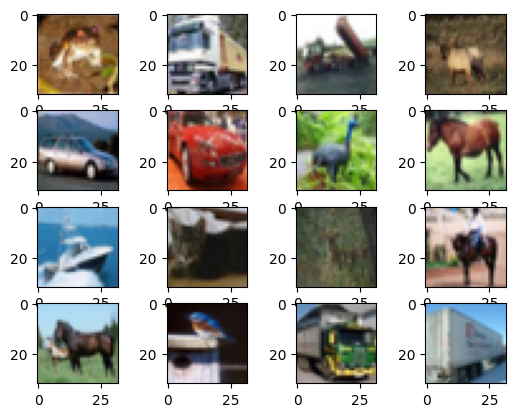

In [78]:
img_batch_to_modify = tf.Variable(train_imgs[:16])
lbls = train_lbls[:16]
modify_data = tf.data.Dataset.from_tensor_slices((img_batch_to_modify, lbls)).batch(16)
lbls = np.reshape(lbls,16)

plot_imgs(img_batch_to_modify.numpy())

In [79]:
model.evaluate(modify_data)

1/1 [==============================] - 0s 16ms/step - loss: 0.0361 - accuracy: 1.0000


[0.036093421280384064, 1.0]

In [80]:
# lr = 0.25
max_norm = 1.0

loss=1.6145291328430176 acc=0.8125


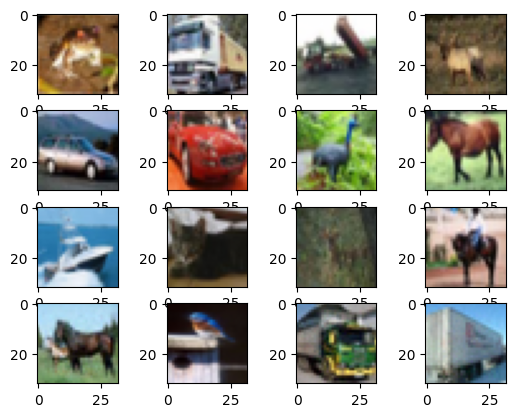

In [82]:
with tf.GradientTape() as tape:
    tape.watch(img_batch_to_modify)
    
    logits = model(img_batch_to_modify)
    
    preds = tf.argmax(logits, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbls),tf.float32))
        
    xent_v = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=lbls)
    xent = tf.reduce_mean(xent_v)

grads = tape.gradient(xent, img_batch_to_modify)
#img_batch_to_modify.assign_add(lr * grads)
grads = tf.clip_by_norm(grads, max_norm)
img_batch_to_modify.assign_add(grads)
img_batch_to_modify = tf.Variable(tf.clip_by_value(img_batch_to_modify, 0.0, 1.0))

print(f"loss={xent}", f"acc={acc}")
plot_imgs(img_batch_to_modify.numpy())

## Adversarial Training

In [89]:
def adversarial_training(model, dataset, epochs, steps_per_epoch, adv_max_norm=2.0):
    for e in range(epochs):
        print(f"Epoch {e+1}/{epochs}")
        
        normal_xent = 0.0
        adv_xent = 0.0
        normal_acc = 0.0
        adv_acc = 0.0
        for step, (imgs, lbls) in enumerate(dataset):
            if step >= steps_per_epoch:
                break
                
            print(f'\r{step+1}', end="")
    
            # creating adversarial batch and training normal
            with tf.GradientTape(persistent=True) as adv_tape:
                adv_tape.watch(imgs)
                adv_tape.watch(model.trainable_variables)
                
                logits = model(imgs)
                
                # statistics on imgs
                preds = tf.argmax(logits, axis=1, output_type=tf.int32)
                acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbls),tf.float32))

                #xent_v = model.loss(logits, lbls)
                xent_v = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=lbls)
                xent = tf.reduce_mean(xent_v)
            
            model_grads = adv_tape.gradient(xent, model.trainable_variables)
            adv_grad = adv_tape.gradient(xent, imgs)
            adv_imgs = imgs + (tf.clip_by_norm(adv_grad, adv_max_norm))
            adv_imgs = tf.clip_by_value(adv_imgs, 0.0, 1.0)
            
            normal_xent = (step)/(step+1) * normal_xent + 1/(step+1) * xent
            normal_acc = (step)/(step+1) * normal_acc + 1/(step+1) * acc
            
            model.optimizer.apply_gradients(zip(model_grads, model.trainable_variables))
            
            # training on adversarial
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_variables)
                adv_logits = model(adv_imgs)
                
                # statistics on adv_imgs
                preds = tf.argmax(adv_logits, axis=1, output_type=tf.int32)
                acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbls),tf.float32))

                #xent_v = model.loss(logits, lbls)
                xent_v = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=adv_logits, labels=lbls)
                xent = tf.reduce_mean(xent_v)
            
            grads = tape.gradient(xent, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            adv_xent = (step)/(step+1) * adv_xent + 1/(step+1) * xent
            adv_acc = (step)/(step+1) * adv_acc + 1/(step+1) * acc
        
        print(f"normal: loss={normal_xent}, acc={normal_acc}   adv: loss={adv_xent}, acc={adv_acc}")
        
#graph_adversarial_training = tf.function(adversarial_training)

In [90]:
model = build_model()
model.compile(optimizer="adam", loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [91]:
#graph_adversarial_training(model, train_data, 15, 500)
adversarial_training(model, train_data, 15, 500)

Epoch 1/15
500normal: loss=1.4815912246704102, acc=0.4607968032360077   adv: loss=1.4739048480987549, acc=0.4621656835079193
Epoch 2/15
500normal: loss=1.0814392566680908, acc=0.6124030351638794   adv: loss=1.0995794534683228, acc=0.6054498553276062
Epoch 3/15
500normal: loss=0.8987919688224792, acc=0.6824500560760498   adv: loss=0.9369876980781555, acc=0.6680842638015747
Epoch 4/15
500normal: loss=0.7640010714530945, acc=0.7318443059921265   adv: loss=0.8219841718673706, acc=0.7117967009544373
Epoch 5/15
500normal: loss=0.654461681842804, acc=0.7712563276290894   adv: loss=0.7306306958198547, acc=0.7441219091415405
Epoch 6/15
500normal: loss=0.5635358095169067, acc=0.8027411103248596   adv: loss=0.6583461165428162, acc=0.7708659172058105
Epoch 7/15
500normal: loss=0.48178330063819885, acc=0.8328062891960144   adv: loss=0.5925685167312622, acc=0.7948656678199768
Epoch 8/15
500normal: loss=0.4121329188346863, acc=0.8561721444129944   adv: loss=0.5394217371940613, acc=0.8145570158958435


In [92]:
model.evaluate(test_data)

79/79 [==============================] - 1s 7ms/step - loss: 1.4263 - accuracy: 0.6811


[1.4263378381729126, 0.6811000108718872]

In [93]:
model.save('res_cifar10_adversarial.keras')

In [ ]:
model = tfk.models.load_model('res_cifar10_adversarial.keras')

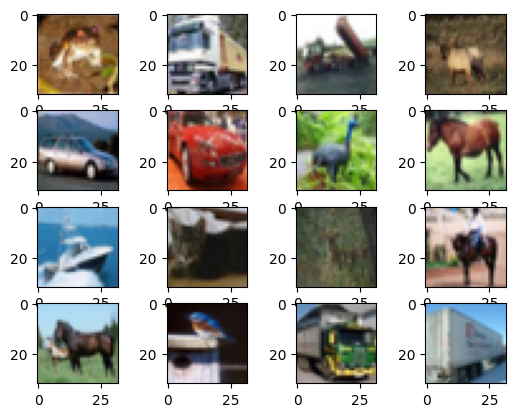

1/1 [==============================] - 0s 15ms/step - loss: 0.0125 - accuracy: 1.0000
tf.Tensor(0.01098749, shape=(), dtype=float32)
loss=0.012512102723121643 acc=1.0


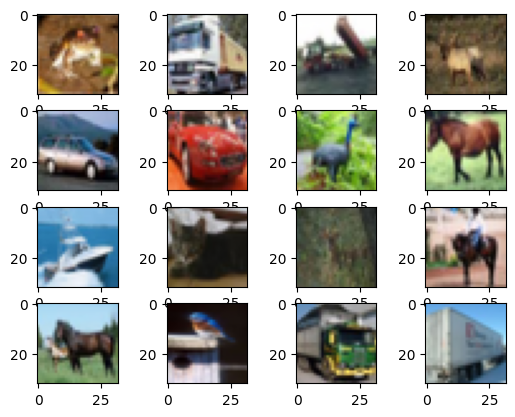

In [98]:
img_batch_to_modify = tf.Variable(train_imgs[:16])
lbls = train_lbls[:16]
modify_data = tf.data.Dataset.from_tensor_slices((img_batch_to_modify, lbls)).batch(16)
lbls = np.reshape(lbls,16)

plot_imgs(img_batch_to_modify.numpy())

model.evaluate(modify_data)

with tf.GradientTape() as tape:
    tape.watch(img_batch_to_modify)
    
    logits = model(img_batch_to_modify)
    
    preds = tf.argmax(logits, axis=1, output_type=tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbls),tf.float32))
        
    xent_v = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=lbls)
    xent = tf.reduce_mean(xent_v)

grads = tape.gradient(xent, img_batch_to_modify)
#img_batch_to_modify.assign_add(lr * grads)
grads = tf.clip_by_norm(grads, 10.0)
old = tf.Variable(img_batch_to_modify)
img_batch_to_modify.assign_add(grads)
img_batch_to_modify = tf.Variable(tf.clip_by_value(img_batch_to_modify, 0.0, 1.0))

print(tf.reduce_max(old-img_batch_to_modify))

print(f"loss={xent}", f"acc={acc}")
plot_imgs(img_batch_to_modify.numpy())

**Conclusion**: Seems to be more robust :)